In [8]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,ConcatDataset
import math
from torch import nn
from lib.models import RegNet
from torch.nn.functional import relu
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np
import random

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# CONFIG = {
#     'WINDOW_SIZE':5000,
#     'BATCH_SIZE':1024,
#     'LEARNING_RATE':3e-3,
#     'DEVICE':'cuda',
#     'SEQUENCE_LENGTH':7
# }
import json
PROJECT_DIR = f'projects/17'
with open(f'{PROJECT_DIR}/config.json','r') as f:
    CONFIG = json.load(f)

In [9]:
from lib.models import Dumbledorev2
from lib.datasets import EpochedDataset,SequencedDatasetv2
from lib.ekyn import get_ekyn_ids,load_ekyn_pt

train_idx,test_idx = train_test_split(get_ekyn_ids(),test_size=.25,random_state=0)
trainloader = DataLoader(ConcatDataset([SequencedDatasetv2(idx=idx,condition=condition,sequence_length=CONFIG['SEQUENCE_LENGTH'],batch_size=CONFIG['BATCH_SIZE']) for idx in train_idx for condition in ['Vehicle','PF']]),batch_size=1,shuffle=True)
devloader = DataLoader(ConcatDataset([SequencedDatasetv2(idx=idx,condition=condition,sequence_length=CONFIG['SEQUENCE_LENGTH'],batch_size=CONFIG['BATCH_SIZE']) for idx in test_idx for condition in ['Vehicle','PF']]),batch_size=1,shuffle=True)
model = Dumbledorev2(encoder_path=f'projects/6',sequence_length=CONFIG['SEQUENCE_LENGTH'],hidden_dim=CONFIG['HIDDEN_DIM'],layers=CONFIG['LAYERS'],embedding=CONFIG['EMBEDDING'],frozen=CONFIG['FROZEN'],batch_size=CONFIG['BATCH_SIZE'])
model.load_state_dict(torch.load(f=f'{PROJECT_DIR}/best.f1.pt', map_location='cpu'))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=CONFIG['LEARNING_RATE'])
model.to(CONFIG['DEVICE']);

/home/andrew/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [5]:
lossi = []
trainlossi = []
trainf1 = []
devlossi = []
devf1 = []
model.train()
from lib.utils import training_loop,development_loop
for i in tqdm(range(1000)):
    loss,f1 = training_loop(model=model,trainloader=trainloader,criterion=criterion,optimizer=optimizer,device=CONFIG['DEVICE'])
    trainlossi.append(loss)
    trainf1.append(f1)

    loss,f1 = development_loop(model=model,devloader=devloader,criterion=criterion,device=CONFIG['DEVICE'])
    devlossi.append(loss)
    devf1.append(f1)

    fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,4))
    ax[0].plot(trainlossi)
    ax[0].plot(devlossi)
    ax[1].plot(trainf1)
    ax[1].plot(devf1)
    plt.savefig('loss.jpg')
    plt.close()

  1%|          | 8/1000 [00:51<1:46:34,  6.45s/it]

In [10]:
from lib.utils import evaluate
evaluate(devloader,model,criterion,CONFIG['DEVICE'])

100%|██████████| 264/264 [00:02<00:00, 94.79it/s] 


(0.16205843220240873,
 {'precision': 0.8714022782892427,
  'recall': 0.9163789979621386,
  'f1': 0.8910407298802511},
 tensor([2., 2., 2.,  ..., 2., 2., 2.]),
 tensor([2., 2., 2.,  ..., 2., 2., 2.]),
 tensor([[2.5226e-04, 7.0344e-05, 9.9968e-01],
         [2.2434e-05, 1.3435e-04, 9.9984e-01],
         [1.0244e-05, 1.0561e-04, 9.9988e-01],
         ...,
         [2.0937e-05, 2.9618e-03, 9.9702e-01],
         [1.6745e-05, 2.1611e-03, 9.9782e-01],
         [4.4574e-06, 1.0474e-03, 9.9895e-01]]))

100%|██████████| 264/264 [00:01<00:00, 173.53it/s]


100%|██████████| 66/66 [00:00<00:00, 167.91it/s]


              precision    recall  f1-score   support

         0.0       0.76      0.93      0.83       928
         1.0       0.97      0.95      0.96      7839
         2.0       0.95      0.94      0.95      8129

    accuracy                           0.95     16896
   macro avg       0.89      0.94      0.91     16896
weighted avg       0.95      0.95      0.95     16896

0.13352587318513542


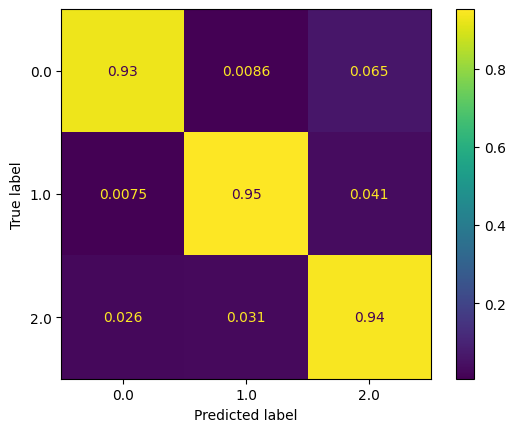

In [18]:
devloader = DataLoader(ConcatDataset([SequencedDatasetv2(idx=idx,condition=condition,sequence_length=CONFIG['SEQUENCE_LENGTH'],batch_size=CONFIG['BATCH_SIZE']) for idx in test_idx[:1] for condition in ['Vehicle','PF']]),batch_size=1,shuffle=False)
loss,report,y_true,y_pred,y_logits = evaluate(devloader,model,criterion,CONFIG['DEVICE'])
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true')
print(classification_report(y_true,y_pred))
print(loss)

In [27]:
len(y_true)

16896

In [26]:
(8640*2)-512

16768

In [ ]:
import matplotlib.patches as patches
start = 0
duration = 1000

fig, ax = plt.subplots(nrows=4,ncols=1,figsize=(16,10),dpi=100,sharex=True)

colors = ['red','green','blue']
epochs = []
for i in range(duration):
    stage = int(y.argmax(axis=1)[start+i])
    ax[3].fill_between([i*5000, (i+1)*5000], y1=-.0003, y2=.0003, color=colors[stage], alpha=0.3)
    epochs.append(i*5000+2500)

y_logits_tmp = torch.tensor([[val]*CONFIG['WINDOW_SIZE'] for val in list(y_logits[start:start+duration].numpy())]).flatten(0,1)

ax[0].stackplot(range(len(y_logits_tmp)),y_logits_tmp[:,0],y_logits_tmp[:,1],y_logits_tmp[:,2],colors=['#FF000080','#00FF0080','#0000FF80'])

ax[1].plot(torch.cat([torch.tensor([[val]*CONFIG['WINDOW_SIZE'] for val in list(y_pred[start:start+duration].numpy())]).flatten()]))
ax[1].set_yticks([0,1,2],['Paradoxical','Slow-Wave','Wakefulness'])
ax[1].margins(0,0)
ax[1].set_ylim([-.1,2.1])
ax[1].set_title('predicted activity')

ax[2].plot(torch.cat([torch.tensor([[val]*CONFIG['WINDOW_SIZE'] for val in list(y_true[start:start+duration].numpy())]).flatten()]))
ax[2].set_yticks([0,1,2],['Paradoxical','Slow-Wave','Wakefulness'])
ax[2].margins(0,0)
ax[2].set_ylim([-.1,2.1])
ax[2].set_title('reference activity')

ax[3].plot(X[start:start+duration].flatten(),'black',linewidth=.3)
ax[3].margins(0,0)
ax[3].set_ylim([-.0003,.0003])
ax[3].set_ylabel('potential energy (Volts)')
ax[3].set_xticks(epochs[::int(duration/20)],range(duration)[::int(duration/20)]);
ax[3].set_title('expert labeling')

red_patch = patches.Patch(color='red', alpha=0.5, label='Paradoxical')
green_patch = patches.Patch(color='green', alpha=0.5, label='Slow-wave')
blue_patch = patches.Patch(color='blue', alpha=0.5, label='Wakefulness')

plt.legend(handles=[red_patch, green_patch,blue_patch],loc='upper left',bbox_to_anchor=(1.04, 1),fancybox=True, shadow=True, ncol=1)
plt.xlabel('epoch (each being 10 seconds)')
plt.savefig('Sleep3.jpg',bbox_inches='tight')